In [1]:
import os
import glob
from PIL import Image
import pandas as pd
from IPython.display import HTML, display

# Функція для форматування зображень (відносний шлях)
def image_formatter(path):
    relative_path = os.path.relpath(path, start=os.getcwd())  # Створюємо відносний шлях
    return f'<img src="{relative_path}" width="100">'

# Функція для створення датафрейму
def to_dataframe(folder_path):
    data = []
    image_formats = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff']  # Допустимі формати

    # Проходимося по файлах у папці
    for file_path in glob.glob(os.path.join(folder_path, '*')):
        try:
            if os.path.splitext(file_path)[-1].lower() in image_formats:
                with Image.open(file_path) as img:
                    color_model = img.mode
                    img_format = img.format
                    channels = len(img.getbands())
                    size_mb = round(os.path.getsize(file_path) / (1024 * 1024), 2)
                    width, height = img.size
                    full_path = os.path.abspath(file_path)
                    data.append({
                        'name': os.path.basename(file_path),
                        'color model': color_model,
                        'format': img_format,
                        'channels': channels,
                        'size': size_mb,
                        'width': width,
                        'height': height,
                        'full path': full_path,
                        'image': full_path  # Додаємо шлях до зображення
                    })
        except Exception as e:
            # Ігноруємо файли, які не є зображеннями
            continue

    df = pd.DataFrame(data)
    return df

# Виклик функції для обробки папки 'photo'
folder_path = './photo'  # Вказуємо шлях до папки зображень
dff = to_dataframe(folder_path)

# Відображення в Jupyter Notebook
display(HTML(dff.to_html(formatters={'image': image_formatter}, escape=False)))

# Збереження у HTML-файл
output_html_path = 'output.html'
with open(output_html_path, 'w', encoding='utf-8') as f:
    f.write(dff.to_html(formatters={'image': image_formatter}, escape=False))
# Відображення зображення в датафреймі за допомогою HTML-форматування
print(f"HTML файл збережено за адресою: {os.path.abspath(output_html_path)}")

,name,color model,format,channels,size,width,height,full path,image
0,1.jpg,RGB,JPEG,3,0.21,1220,600,C:\labi\photo\1.jpg,
1,10.jpg,RGB,JPEG,3,0.01,300,168,C:\labi\photo\10.jpg,
2,11.jpg,RGB,JPEG,3,0.01,300,168,C:\labi\photo\11.jpg,
3,12.jpg,RGB,JPEG,3,0.16,1220,600,C:\labi\photo\12.jpg,
4,13.jpg,RGB,JPEG,3,0.19,1080,720,C:\labi\photo\13.jpg,
5,14.jpg,RGB,JPEG,3,0.24,1220,600,C:\labi\photo\14.jpg,
6,15.jpg,RGB,JPEG,3,0.01,275,183,C:\labi\photo\15.jpg,
7,2.jpg,RGB,JPEG,3,0.60,2000,1414,C:\labi\photo\2.jpg,
8,3.jpg,RGB,JPEG,3,0.01,275,183,C:\labi\photo\3.jpg,
9,4.jpg,RGB,JPEG,3,0.21,1200,580,C:\labi\photo\4.jpg,


HTML файл збережено за адресою: C:\labi\output.html


In [2]:
import os
import random
from PIL import Image, ImageFilter
import numpy as np
import matplotlib.pyplot as plt

# Список кольорових фільтрів
filters = ['red', 'green', 'blue', 'yellow', 'purple', 'cyan']

# Функція для обрізки зображення до квадратної форми
def crop_to_square(image: Image) -> Image:
    width, height = image.size
    min_dim = min(width, height)
    
    # Вираховуємо координати для обрізки
    left = (width - min_dim) // 2
    top = (height - min_dim) // 2
    right = left + min_dim
    bottom = top + min_dim
    
    return image.crop((left, top, right, bottom))

# Функція для накладення фільтру
def apply_color_filter(image: Image, filter_type: str) -> Image:
    # Перетворюємо зображення в numpy масив
    img_array = np.array(image)
    
    if filter_type == 'red':
        img_array[:, :, 1:] = 0  # Оставляємо тільки червоний канал
    elif filter_type == 'green':
        img_array[:, :, [0, 2]] = 0  # Оставляємо тільки зелений канал
    elif filter_type == 'blue':
        img_array[:, :, :2] = 0  # Оставляємо тільки синій канал
    elif filter_type == 'yellow':
        img_array[:, :, 2] = 0  # Залишаємо жовтий (червоний + зелений)
    elif filter_type == 'purple':
        img_array[:, :, 1] = 0  # Залишаємо пурпурний (червоний + синій)
    elif filter_type == 'cyan':
        img_array[:, :, 0] = 0  # Залишаємо голубий (зелений + синій)
    
    return Image.fromarray(img_array)

# Основна функція для створення постера
def create_poster(folder_path, grid_size, output_filename='poster.jpg'):
    num_images_per_row, num_images_per_column = grid_size
    
    # Список всіх зображень у папці (ігноруємо не зображення)
    images = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Перевіряємо, чи є достатньо зображень
    if len(images) < num_images_per_row * num_images_per_column:
        print(f"Помилка! Для данної сітки не вистачає фото! Потрібно {num_images_per_row * num_images_per_column} зображень, а є лише {len(images)}.")
        return
    
    # Перемішуємо зображення, щоб вони не повторювались
    random.shuffle(images)
    
    # Список для збереження зображень
    selected_images = []
    
    # Розрахунок фільтрів для кожного зображення
    selected_filters = random.choices(filters, k=num_images_per_row * num_images_per_column)

    for i in range(num_images_per_row * num_images_per_column):
        # Вибір зображення з випадкового списку
        random_image_name = images[i]
        image_path = os.path.join(folder_path, random_image_name)
        
        # Відкриваємо зображення
        img = Image.open(image_path)
        
        # Обрізаємо до квадратної форми
        img = crop_to_square(img)
        
        # Масштабуємо зображення до однакового розміру
        img = img.resize((500, 500))
        
        # Вибір фільтру для зображення
        color_filter = selected_filters[i]
        img = apply_color_filter(img, color_filter)
        
        selected_images.append(img)
    
    # Створюємо порожнє полотно для постера
    poster_width = 500 * num_images_per_row
    poster_height = 500 * num_images_per_column
    poster = Image.new('RGB', (poster_width, poster_height))
    
    # Розміщуємо зображення на постері
    for row in range(num_images_per_column):
        for col in range(num_images_per_row):
            img_index = row * num_images_per_row + col
            img = selected_images[img_index]
            poster.paste(img, (col * 500, row * 500))
    
    # Створення папки для постерів, якщо вона не існує
    output_folder = 'poster'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Збереження постера в папку
    output_path = os.path.join(output_folder, output_filename)
    poster.save(output_path)

    # Відображаємо постер
    plt.imshow(poster)
    plt.axis('off')
    plt.show()

    print(f"Постер збережено як {output_path}")

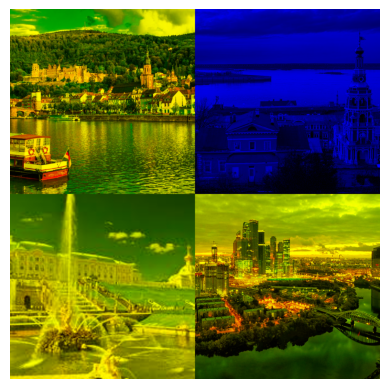

Постер збережено як poster\poster_2x2.jpg


In [3]:
create_poster('photo', (2, 2), 'poster_2x2.jpg')

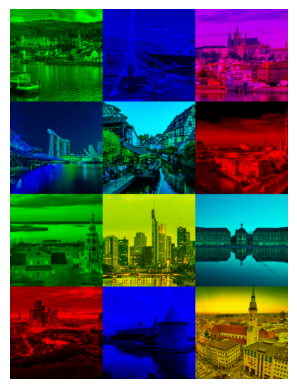

Постер збережено як poster\poster_3x4.png


In [4]:
create_poster('photo', (3, 4), 'poster_3x4.png')

In [5]:
create_poster('photo', (5, 5), 'poster_5x5.jpg')


Помилка! Для данної сітки не вистачає фото! Потрібно 25 зображень, а є лише 14.
